# Genre Classification using Supervised Machine Learning Models

This notebook contains the code to classify tracks with a genre by (1) investigating possible predictive input features and (2) predicting genre labels using 3 supervised classification models: K-Nearest Neighbors (KNN), support vector machines (SVM) and random forest (RF).


> **Highly recommended**: Install [sklearn-intelex](https://pypi.org/project/scikit-learn-intelex/) to speed up model training especially for low-spec machines

In [2]:
!pip install scikit-optimize -q
!pip install imblearn -q
!pip install xgboost -q
!pip install shap -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.0 which is incompatible.
sagemaker-datawran

In [3]:
# general libraries
import warnings
import time
import shap
import os
import pickle
import requests
import joblib
from tqdm import tqdm
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict
warnings.filterwarnings("ignore")

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Resampling
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, SMOTENC, SMOTEN, ADASYN, SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
from imblearn.combine import SMOTETomek, SMOTEENN

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud
from nltk.corpus import stopwords

# Outlier detection
import scipy.stats as stats
from sklearn.ensemble import IsolationForest

# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
import xgboost as xgb

In [33]:
# Utility methods
def evaluate_base_models(X, y, sampling_technique=None, override_models=None, scaler=None, n_splits=5, sort_by_value='ave_val_acc'):
    random_state = 42

    models = {
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'Logistic Regression': LogisticRegression(random_state=random_state, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'ExtraTrees': ExtraTreesClassifier(random_state=random_state),
        'XGBoost': xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y)), random_state=42),
        'LinearSVM': SVC(kernel='linear', random_state=random_state),
        'PolynomialSVM': SVC(kernel='poly', random_state=random_state),
        'RadialSVM': SVC(kernel='rbf', random_state=random_state)
    }

    if override_models:
        models = override_models

    skf = StratifiedKFold(n_splits=n_splits)
    res = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models.items()):
        train_scores, val_scores = [], []
        train_prec, val_prec = [], []
        train_rec, val_rec = [], []
        train_f1, val_f1 = [], []
        train_fbeta, val_fbeta = [], []
        results = {
            'train_scores': [],
            'val_scores': [],
            'train_prec': [],
            'val_prec': [],
            'train_rec': [],
            'val_rec': [],
            'train_f1': [],
            'val_f1': [],
            'y_train': [],
            'y_val': [],
            'train_preds': [],
            'val_preds': []
        }

        steps = []
        if scaler:
            steps.append(scaler)

        if sampling_technique:
            steps.append(sampling_technique)

        steps.append(model)

        pipeline = make_pipeline(*steps)

        start_time = time.time()
        for train_index, val_index in tqdm(skf.split(X_trainval, y_trainval)):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            pipeline.fit(X_train, y_train)

            train_score = pipeline.score(X_train, y_train)
            val_score = pipeline.score(X_val, y_val)

            train_preds = pipeline.predict(X_train)
            val_preds = pipeline.predict(X_val)

            results['train_scores'].append(train_score)
            results['val_scores'].append(val_score)
            results['train_prec'].append(precision_score(y_train, train_preds, average='weighted'))
            results['val_prec'].append(precision_score(y_val, val_preds, average='weighted'))
            results['train_rec'].append(recall_score(y_train, train_preds, average='weighted'))
            results['val_rec'].append(recall_score(y_val, val_preds, average='weighted'))
            results['train_f1'].append(f1_score(y_train, train_preds, average='weighted'))
            results['val_f1'].append(f1_score(y_val, val_preds, average='weighted'))
            results['y_train'].append(y_train)
            results['y_val'].append(y_val)
            results['train_preds'].append(train_preds)
            results['val_preds'].append(val_preds)

        end_time = time.time()
        res[model_name] = {
            'scaling': type(scaler).__name__ if scaler else 'None',
            'resampling_technique': type(sampling_technique).__name__ if sampling_technique else 'None',
            'ave_train_acc': np.mean(results['train_scores']) * 100,
            'ave_val_acc': np.mean(results['val_scores']) * 100,
            'ave_train_prec': np.mean(results['train_prec']) * 100,
            'ave_val_prec': np.mean(results['val_prec']) * 100,
            'ave_train_rec': np.mean(results['train_rec']) * 100,
            'ave_val_rec': np.mean(results['val_rec']) * 100,
            'ave_train_f1': np.mean(results['train_f1']) * 100,
            'ave_val_f1': np.mean(results['val_f1']) * 100,
            'run_time': end_time - start_time,
            'results' : results
        }

    total_end = time.time()
    elapsed = total_end - total_start
    print(f"Report Generated in {elapsed:.2f} seconds")
    report = pd.DataFrame(res).T.sort_values(by=sort_by_value, ascending=False)
    return report

def evaluate_sampling_techniques(X_trainval, y_trainval, use_sampling=True, scaler=None, random_state=42):
    sampling_techniques = {
        'SMOTE': SMOTE(random_state=random_state, n_jobs=-1),
        'ADASYN': ADASYN(random_state=random_state, n_jobs=-1),
        # 'BorderlineSMOTE': BorderlineSMOTE(random_state=random_state, n_jobs=-1),
        'NearMiss': NearMiss(n_jobs=-1),
        'TomekLinks': TomekLinks(n_jobs=-1),
        'SMOTETomek': SMOTETomek(random_state=random_state, n_jobs=-1),
        'SMOTEENN': SMOTEENN(random_state=random_state, n_jobs=-1)
    }

    # Dictionary to hold DataFrames for each sampling technique
    sampling_reports = defaultdict(pd.DataFrame)

    if use_sampling:
        for technique_name, technique in sampling_techniques.items():
            print(f"Evaluating models with {technique_name} sampling technique with {scaler.__class__.__name__ if scaler else 'No scaling'}...")
            report = evaluate_base_models(X_trainval, y_trainval, sampling_technique=technique, scaler=scaler).sort_values(by='ave_val_acc', ascending=False)
            print(report)
            sampling_reports[technique_name] = report
    else:
        sampling_reports[technique_name] = evaluate_base_models(X_trainval, y_trainval, scaler=scaler).sort_values(by='ave_val_acc', ascending=False)

    sampling_reports_df = pd.concat(sampling_reports, names=['Sampling Technique', 'Model']).reset_index()

    return sampling_reports_df

def tune_top_models(X, y, top_algorithms, sampling_technique, scorer='accuracy', n_splits=3):
    random_state = 42

    models_and_grids = {
     'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=random_state),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'class_weight': ['balanced', None],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'fit_intercept': [True, False],
            'dual': [True, False],
            'max_iter': [50, 100, 200],
            'multi_class': ['auto', 'ovr', 'multinomial'],
            'l1_ratio': [None, 0.25, 0.5, 0.75],
            'warm_start': [True, False],
            'verbose': [0, 1]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'params': {
            'splitter': ['best', 'random'],
            'max_depth': [8, 12, 16, 20],
            'min_samples_split': [5, 10, 15, 20],
            'max_features': [None, 'sqrt', 'log2'],
            'criterion': ['gini', 'entropy'],
            'class_weight' : ['balanced', None]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=random_state),
        'params': {
            'n_estimators': [100, 150, 200, 250],
            'learning_rate': [0.001, 0.01, 0.1, 1],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y)), random_state=random_state),
        'params': {
            'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
            'n_estimators': [50, 100, 150, 200, 250],
            'max_depth': [2, 3, 5, 7, 9],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 3, 4],
            'criterion': ['squared_error', 'friedman_mse']
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=random_state),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy']
        }
    },
    'LinearSVM': {
        "model": SVC(kernel='linear', random_state=random_state),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "random_state": [11]
        }
    },
    'PolynomialSVM': {
        "model": SVC(kernel='poly', random_state=random_state),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "degree": [2, 3, 4],
            "coef0": [0.0, 1.0, 2.0],
            "random_state": [11]
        }
    },
    'RadialSVM': {
        "model": SVC(kernel='rbf', random_state=random_state),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "gamma": ['scale', 'auto'],
            "random_state": [11]
        }
    }
  }

    print(f'The top algorithms are: {top_algorithms}')

    params_and_metrics = {}

    for name in top_algorithms:
        mg = models_and_grids.get(name)
        model = mg['model']
        params = mg['params']
        print(f'Tuning for {name}')

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        pipeline = Pipeline([
            ('Scaling', StandardScaler()),
            ('Sampler', sampling_technique),
            ('Model', model)
        ])

        # Update the parameter grid to work with pipeline
        params = {f'Model__{key}': params[key] for key in params}

        # Bayesian optimization
        bayes_clf = BayesSearchCV(pipeline, params, cv=StratifiedKFold(n_splits=n_splits), n_iter=20, scoring=scorer, n_jobs=-1, verbose=0)
        start = time.time()

        bayes_clf.fit(X_train, y_train)

        end = time.time()

        # Extract results
        best_model = bayes_clf.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_test)

        train_accuracy = accuracy_score(y_train, train_pred)
        val_accuracy = accuracy_score(y_test, val_pred)
        train_recall = recall_score(y_train, train_pred, average='weighted')
        val_recall = recall_score(y_test, val_pred, average='weighted')

        # Additional metrics
        train_f1 = f1_score(y_train, train_pred, average='weighted')
        val_f1 = f1_score(y_test, val_pred, average='weighted')
        train_precision = precision_score(y_train, train_pred, average='weighted')
        val_precision = precision_score(y_test, val_pred, average='weighted')

        params_and_metrics[name] = {
            'best_params': bayes_clf.best_params_,
            'train_accuracy': train_accuracy,
            'test_accuracy': val_accuracy,
            'train_recall': train_recall,
            'test_recall': val_recall,
            'train_precision': train_precision,  # Added
            'test_precision': val_precision,  # Added
            'train_f1': train_f1,  # Added
            'val_f1': val_f1,  # Added
            'runtime': end - start,
        }

    params_and_metrics = pd.DataFrame(params_and_metrics)
    return params_and_metrics.T

def url_exists(url):
    try:
        response = requests.head(url)
        return response.status_code == 200
    except:
        return False

def is_url(string):
    return string.startswith("http://") or string.startswith("https://")

def load_or_run(filepath, func, *args, **kwargs):
    if (is_url(filepath) and url_exists(filepath)) or os.path.exists(filepath):
        dataframe = pd.read_csv(filepath)
    else:
        dataframe = func(*args, **kwargs)
        dataframe.to_csv(filepath)
    return dataframe

def plot_line_comparison_models(df, metric, title, xlabel, ylabel):
    pivot_df = df.pivot(index='Sampling Technique', columns='Model', values=metric)

    # Plotting
    plt.figure(figsize=(14, 8))

    # Determine the appropriate color map based on the number of columns
    num_columns = len(pivot_df.columns)
    if num_columns <= 10:
        colormap = plt.cm.tab10
    elif num_columns <= 20:
        colormap = plt.cm.tab20
    else:
        colormap = plt.cm.viridis

    unique_colors = colormap(np.linspace(0, 1, num_columns))

    # Use the palette in the plot
    for i, (column, color) in enumerate(zip(pivot_df.columns, unique_colors)):
        plt.plot(pivot_df.index, pivot_df[column], marker='o', label=column, color=color)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_bar_comparison_models(df, metric, title, xlabel, ylabel):
    # Create a new column that combines "Model" and "Sampling Technique"
    df['Model_Sampling'] = df['Model'] + ' + ' + df['Sampling Technique']

    # Sort the DataFrame based on the metric
    df_sorted = df.sort_values(by=metric)

    # Plotting
    plt.figure(figsize=(14, 8))
    plt.barh(df_sorted['Model_Sampling'], df_sorted[metric], color='#90EE90')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

def plot_clustered_barh(df_with_sampling, df_without_sampling, metric, xlabel):
    df = pd.concat([df_with_sampling, df_without_sampling])

    df['Model_Sampling'] = df['Model'] + ' with ' + df['Sampling Technique']

    sorted_models = df_with_sampling.sort_values(by=metric, ascending=True)['Model'].tolist()

    plt.figure(figsize=(10, 8))

    y_pos = 0

    color_with_sampling = plt.cm.Blues(0.6)  # Fixed color for models with sampling
    color_without_sampling = plt.cm.Reds(0.6)  # Fixed color for models without sampling

    for model in sorted_models:
        subset_without = df[(df['Model'] == model) & (df['Sampling Technique'] == 'No Sampling')]
        subset_with = df[(df['Model'] == model) & (df['Sampling Technique'] != 'No Sampling')]

        y_labels_without = subset_without['Model_Sampling']
        x_values_without = subset_without[metric]
        plt.barh(y_labels_without, x_values_without, color=color_without_sampling)

        y_labels_with = subset_with['Model_Sampling']
        x_values_with = subset_with[metric]
        plt.barh(y_labels_with, x_values_with, color=color_with_sampling)

        for i, val in enumerate(x_values_without):
            plt.text(val - 6, y_pos + i, f"{val:.2f}%", va='center', color='white', fontsize=9)

        for i, val in enumerate(x_values_with):
            plt.text(val - 6, y_pos + i + len(x_values_without), f"{val:.2f}%", va='center', color='white', fontsize=9)

        y_pos += len(subset_with) + len(subset_without)

    plt.xlabel(xlabel)
    plt.ylabel('Model')
    plt.show()


def plot_model_base_hypertuned_comparison(title, baseline_recall, baseline_fbeta, hypertuned_recall, hypertuned_fbeta):
    labels = ['Recall', 'F-Beta']
    baseline_scores = [baseline_recall, baseline_fbeta]
    hypertuned_scores = [hypertuned_recall, hypertuned_fbeta]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()

    rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='#add8e6')
    rects2 = ax.bar(x + width/2, hypertuned_scores, width, label='Hypertuned', color='#ffcccb')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 20 points vertical offset from the top of the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -20),  # 20 points vertical offset from the top of the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()


def evaluate_model(model, X_trainval, y_trainval, X_holdout, y_holdout, target_names,
                   scaler=None, sampling_technique=None, features=None, filename=None):
    
    if features:
        X_trainval = X_trainval[features]
        X_holdout = X_holdout[features]

    steps = []
    if scaler:
        steps.append(('scaler', scaler))
    if sampling_technique:
        steps.append(('sampler', sampling_technique))
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    pipeline.fit(X_trainval, y_trainval)

    if filename:
        joblib.dump(pipeline, filename + '.pkl')

    y_pred = pipeline.predict(X_holdout)

    print("Classification Report:")
    print(classification_report(y_holdout, y_pred, target_names=target_names))
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(y_holdout, y_pred)
    print(conf_matrix)
    ConfusionMatrixDisplay(conf_matrix, display_labels=target_names).plot(cmap='Blues', values_format='.0f')
    plt.title('Confusion Matrix')
    plt.show()

    y_train_preds = pipeline.predict(X_trainval)
    train_recall = recall_score(y_trainval, y_train_preds, average='weighted')
    test_recall = recall_score(y_holdout, y_pred, average='weighted')
    precision = precision_score(y_holdout, y_pred, average='weighted')
    f1 = f1_score(y_holdout, y_pred, average='weighted')
    train_accuracy = accuracy_score(y_trainval, y_train_preds)
    test_accuracy = accuracy_score(y_holdout, y_pred)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print(f"Training Recall: {train_recall}")
    print(f"Test Recall: {test_recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")

    return pipeline, test_accuracy

In [5]:
# # Mount GDrive folders
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# # Set home directory
# import os
# home_dir = "/content/drive/MyDrive/Colab Notebooks/Sprint 3/"
# os.chdir(home_dir)

In [7]:
DIRECTORY = 'https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/'

## 1. Read and check values of playlist sets

### 1.1. Set genres for prediction

In [5]:
genre_names = ['happy_opm', 'sad_opm', 'chill_opm', 'hugot_opm']
# genre_names = ["Alternative Rock", "Hip-Hop", 'EDM', 'OPM']

### 1.2. Read and check tracks data for each genre

Collect genre playlist data

In [8]:
playlist_df_list = []
for genre in tqdm(genre_names):
    filename = DIRECTORY +genre.lower()+'_playlist_data.csv'
    print(filename)
    pdf = pd.read_csv(filename)
    pdf['genre'] = genre.lower()
    playlist_df_list.append(pdf)

 25%|██▌       | 1/4 [00:00<00:00,  7.04it/s]

https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/happy_opm_playlist_data.csv
https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/sad_opm_playlist_data.csv


100%|██████████| 4/4 [00:00<00:00,  9.31it/s]

https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/chill_opm_playlist_data.csv
https://raw.githubusercontent.com/jmgang/SpoTwoFy-project-notebooks/main/data/playlists/hugot_opm_playlist_data.csv


Collect genre track data

In [9]:
track_df_list = []
for genre in tqdm(genre_names):
    tdf = pd.read_csv(DIRECTORY+genre.lower()+'_playlist_tracks_data.csv')
    tdf = tdf[~tdf.duplicated(subset=['track_id'])] # keep only 1 track id, relevant for older playlist data
    tdf['genre'] =  genre.lower()
    track_df_list.append(tdf)

100%|██████████| 4/4 [00:00<00:00,  8.64it/s]


Concatenate playlist data

In [10]:
playlist_df = pd.concat(playlist_df_list)
playlist_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,39,lopezalyssa03,Alyssa L,412,happy_opm
1,0j1DsJ4OxzbWGYCRCblGI9,happy opm beats makes me happy,66,maicarbdn,maics,41,happy_opm
2,44qyXcUE1Q4AdREcNv72Wh,Happy opm,20,31plraqzzymuw2xz3ewj4waihiq4,Rain_and_candy,1,happy_opm
3,37i9dQZF1EIhkcT9SIIIOn,Happy OPM Mix,50,spotify,Spotify,0,happy_opm
4,3fSyM0XFwRNICakfaw7a9A,Happy OPM Rap,15,mk92hiq1kx56pw9twvobhxbwe,Janmattbondoc,0,happy_opm


In [11]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 4
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   playlist_id            32 non-null     object
 1   playlist_name          32 non-null     object
 2   playlist_total_tracks  32 non-null     int64 
 3   owner_id               32 non-null     object
 4   owner_name             32 non-null     object
 5   total_followers        32 non-null     int64 
 6   genre                  32 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.0+ KB


Get genre playlist tally

In [12]:
playlist_df['genre'].value_counts()

chill_opm    10
sad_opm       9
happy_opm     8
hugot_opm     5
Name: genre, dtype: int64

Concatenate playlist data

In [13]:
tracks_df = pd.concat(track_df_list)
tracks_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre,duration
0,3rcIETyqsnaFShhWCtywaA,0.796,0.810,3,-3.973,0,0.0347,0.0119,0.000136,0.1250,...,5TNuvf8y7Y3QLXsNaIYCYX,Janella Salvador,1.0,5ExrCnkKUNwQHtzzAVdL4B,2015-01-01,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.014433,happy_opm,NaN
1,0wDOW3KujYyW6hIFmhHgIF,0.730,0.746,3,-5.349,1,0.0312,0.0862,0.000000,0.1690,...,2q1YvyrLqKmBqNjIozl2Ne,Harana,1.0,49SJlnu4AMpyHkMSymozsN,2015-01-01,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.198667,happy_opm,NaN
2,0o5Vy8oK1sfMsHD2Dr6D4k,0.540,0.827,3,-4.958,0,0.1230,0.2760,0.000014,0.2190,...,6aiCKnIN68hohzU3ZzNq48,Sarah Geronimo,1.0,6XyCKRUSZTALq3AJgb7Dqu,2014-10-04,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.186883,happy_opm,NaN
3,2Ccg5O8xZUtfXloVOykOiu,0.598,0.795,8,-1.602,1,0.0497,0.6230,0.000193,0.0971,...,6aiCKnIN68hohzU3ZzNq48,Sarah Geronimo,1.0,2MCThGZYlAQRw3HDjkIODU,2015-12-04,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,4.084217,happy_opm,NaN
4,4ai7c2BUjNpElhZdZDH7qF,0.764,0.894,0,-2.892,1,0.0327,0.2270,0.000000,0.0906,...,0XOSmu9Qn1agQULUVe0dAK,Inigo Pascual,1.0,7dT7OfZcmX7HjE8EBqehEF,2016-10-21,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.520000,happy_opm,NaN


In [14]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793 entries, 0 to 235
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1793 non-null   object 
 1   danceability      1793 non-null   float64
 2   energy            1793 non-null   float64
 3   key               1793 non-null   int64  
 4   loudness          1793 non-null   float64
 5   mode              1793 non-null   int64  
 6   speechiness       1793 non-null   float64
 7   acousticness      1793 non-null   float64
 8   instrumentalness  1793 non-null   float64
 9   liveness          1793 non-null   float64
 10  valence           1793 non-null   float64
 11  tempo             1793 non-null   float64
 12  track_name        1793 non-null   object 
 13  popularity        1793 non-null   int64  
 14  duration_ms       1793 non-null   int64  
 15  artist_id         1793 non-null   object 
 16  artist_name       1793 non-null   object 
 

Get genre tracks tally

In [15]:
tracks_df['genre'].value_counts()

chill_opm    884
sad_opm      517
hugot_opm    236
happy_opm    156
Name: genre, dtype: int64

## 2. Refine the training data

**Refinement 1**

Get only *top 10 most followed playlists* per genre.

>Q: Try out keeping top 15 most followed playlists and see what results youll get.

In [16]:
#.head() will show top 10 followed playlists
# since playlists csv is already ordered by decreasing total followers
top_playlists_df = playlist_df.groupby(['genre']).head(15)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,39,lopezalyssa03,Alyssa L,412,happy_opm
1,0j1DsJ4OxzbWGYCRCblGI9,happy opm beats makes me happy,66,maicarbdn,maics,41,happy_opm
2,44qyXcUE1Q4AdREcNv72Wh,Happy opm,20,31plraqzzymuw2xz3ewj4waihiq4,Rain_and_candy,1,happy_opm
3,37i9dQZF1EIhkcT9SIIIOn,Happy OPM Mix,50,spotify,Spotify,0,happy_opm
4,3fSyM0XFwRNICakfaw7a9A,Happy OPM Rap,15,mk92hiq1kx56pw9twvobhxbwe,Janmattbondoc,0,happy_opm
5,2qAKpsuCEeCGaJGO35Mnsw,happy OPM,15,versixto,Ver Bons,0,happy_opm
6,1fYgPkWCK6d44y3KK6YIzg,Happy opm,18,a5guo8pp08gvk6qj0p9itquti,jerald,0,happy_opm
7,4UmfJGF1MGrH9tAo6VxxiL,Happy Opm,12,che.diaz-my,che.diaz-my,0,happy_opm
0,6m5FYwuInDa8tgmFDKux1V,Sad OPM Tagalog Songs,46,edwenjohn,edwenjohn,3690,sad_opm
1,1r7HjVVRuKIOYXKPRMe9Si,Sad OPM Session,366,12136361493,Remee Castro,3461,sad_opm


In [17]:
# Filter keeping only top 10 playlists
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]

In [18]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

chill_opm    884
sad_opm      517
hugot_opm    236
happy_opm    156
Name: genre, dtype: int64

**Refinement 2**

Remove tracks that appear in different genre playlists - get only *unique tracks* per genre

In [19]:
# View duplicated
# Use artist id and track name to ensure uniqueness
tracks_df[tracks_df.duplicated(subset=['artist_id','track_name'])]

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artist_id,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre,duration
51,64G8ywuyGGQl4S7U2a6XJf,0.284,0.281,11,-11.413,1,0.0341,0.438,0.001040,0.1020,...,1YlibpAvhJBbMZMBwN1KGv,The Juans,1.0,70YCM7kgIwLvCGRxkQl9BJ,2023-09-01,37i9dQZF1EIfbm7qJeVMSu,Sad OPM Mix,5.065617,sad_opm,NaN
57,2KjZEVkRS7wStfRygdRnso,0.503,0.482,4,-4.736,1,0.0288,0.161,0.000000,0.1870,...,"['4qFxP3qN9GsnZDOkAE6x2m', '0rZRTXEmmPmx6gt92t...","['December Avenue', 'Moira Dela Torre']",2.0,7eXlJM2M5i3iDd8xgd0qwr,2019-12-20,37i9dQZF1EIfbm7qJeVMSu,Sad OPM Mix,4.462650,sad_opm,NaN
58,1l7TuyIge9siMw39a0dqXd,0.554,0.329,7,-10.678,1,0.0446,0.650,0.000079,0.0924,...,7LvDTuFCBv08xm6u1pOMK0,TJ Monterde,1.0,3BNVpFNizGDG0IxfsEYhXU,2014-06-16,37i9dQZF1EIfbm7qJeVMSu,Sad OPM Mix,3.991333,sad_opm,NaN
62,3Hsjzl5kBbCAMaJxg1OTwK,0.313,0.237,9,-14.537,1,0.0451,0.855,0.000382,0.0961,...,2U5mF0PZqGu6glnz55yY0y,John Roa,1.0,2DgTTNbbKwiPMUaAqeRmuf,2018-02-14,37i9dQZF1EIfbm7qJeVMSu,Sad OPM Mix,5.606150,sad_opm,NaN
72,7o7FQ0zdggnSP8nrsAIy1m,0.660,0.373,7,-7.875,1,0.0290,0.701,0.000000,0.2260,...,7tKpXx21KVUOR6vvDs6xtg,I Belong to the Zoo,1.0,0ULmsFDDkOnwetCGrEvCSl,2018-04-28,37i9dQZF1EIfbm7qJeVMSu,Sad OPM Mix,4.618300,sad_opm,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,7sbCGaQ050jET6mQpcpimT,0.552,0.446,6,-9.800,1,0.0316,0.396,0.000000,0.1130,...,4flyhH0Zv4Dub2HzZQN7tZ,Ezra Band,NaN,3RLoOQMhkHWLPgRndEE0zs,2017-03-03,1QEcxHqZEBqbcPrC3mrdcU,Hugot OPM,NaN,hugot_opm,268693.0
220,6ZHKSAcOQpaZuQOruOPH8R,0.457,0.490,6,-7.312,1,0.0502,0.807,0.000000,0.1420,...,1Imlf2KHeVnyY2bkZe1bNC,Klarisse,NaN,5zOnrSjnInU8ODThMwEdbx,2017-07-28,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,278973.0
222,4r7uXnwJsxhrqceeyvfrXF,0.492,0.574,2,-8.907,1,0.0357,0.137,0.000002,0.0844,...,2XHTklRsNMOOQT56Zm3WS4,Parokya Ni Edgar,NaN,6Mzh5Y1hNNwER2xnACwq8V,2014-03-16,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,352680.0
229,4Yp1a9HZjtnNCd577RLYp2,0.686,0.420,2,-8.320,1,0.0308,0.723,0.000000,0.1190,...,2JEIN1g27pZdm3hKB9EwE5,Mark Carpio,NaN,6E5TwOXhw6KyhX4P0p9vdK,2015-01-15,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,219966.0


>Q: Which genres have the highest number of duplicated tracks (tracks classified under two or more genres)?

In [20]:
duplicated_tracks_df = tracks_df[tracks_df.duplicated(subset=['artist_id', 'track_name'], keep=False)]
duplicated_tracks_df.groupby('genre')['track_id'].count()

genre
chill_opm    196
happy_opm     29
hugot_opm    109
sad_opm      151
Name: track_id, dtype: int64

>Q: Which tracks were classified to the most number of genres?

In [21]:
duplicated_tracks_df.groupby(['track_id', 'track_name'])[['genre']]\
                    .agg(count=('genre', 'count'),
                         genres=('genre', lambda x: list(x)))\
                    .sort_values(by='count', ascending=False)

,,count,genres
track_id,track_name,,
0ztDBQdQmdVZvorSmIjMih,Tagpuan,4,"[happy_opm, sad_opm, chill_opm, hugot_opm]"
6FT35oVqQZFiTPL9BLmHOH,Tayo Lang Ang May Alam,3,"[happy_opm, sad_opm, hugot_opm]"
0x2VgHoxUxKFbIUqQur8Fe,Sino,3,"[sad_opm, chill_opm, hugot_opm]"
00mBzIWv5gHOYxwuEJXjOG,Sa Ngalan Ng Pag-Ibig,3,"[sad_opm, chill_opm, hugot_opm]"
0luyrm1L6gjtoLekHOf67t,Masyado Pang Maaga,3,"[sad_opm, chill_opm, hugot_opm]"
...,...,...,...
4nx5AtRlSVoPxTvlA9Al8u,Sino Nga Ba Siya,1,[sad_opm]
4o8yZ5AnripYyuTksF1nK6,Wala Na Talaga,1,[sad_opm]
4pUM81y5Rq7vAUeFhJRBXa,Miracle Nights,1,[happy_opm]


In [22]:
# Filter non-uniquely listed tracks
tracks_df = tracks_df.drop_duplicates(subset=['artist_id','track_name'])
tracks_df.shape

(1514, 25)

In [23]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

chill_opm    744
sad_opm      487
happy_opm    156
hugot_opm    127
Name: genre, dtype: int64

## 3. Compare histogram of features

Choose two genres to compare

In [24]:
compare_genres = ['happy_opm', 'sad_opm']

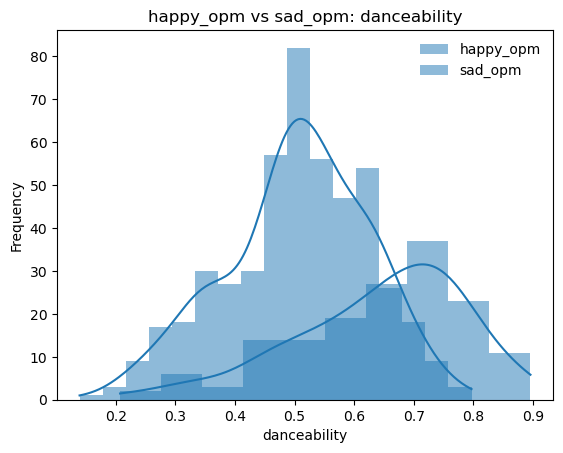

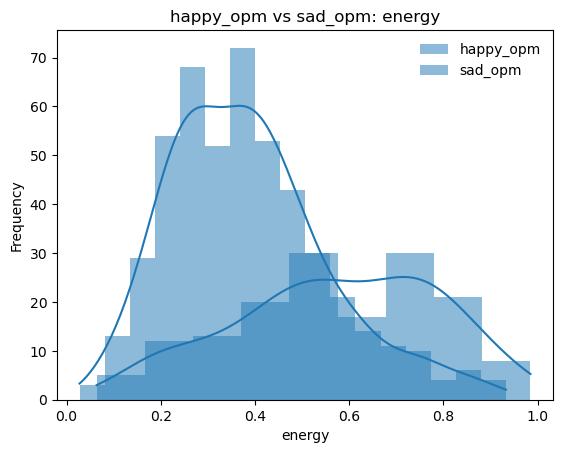

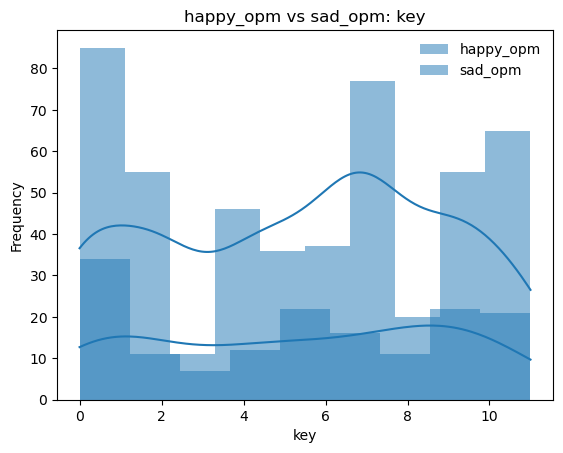

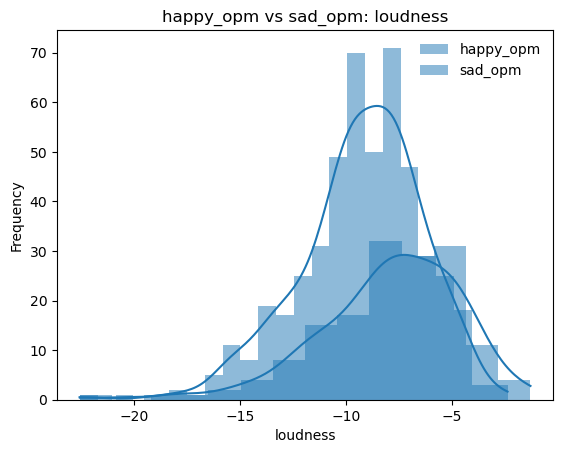

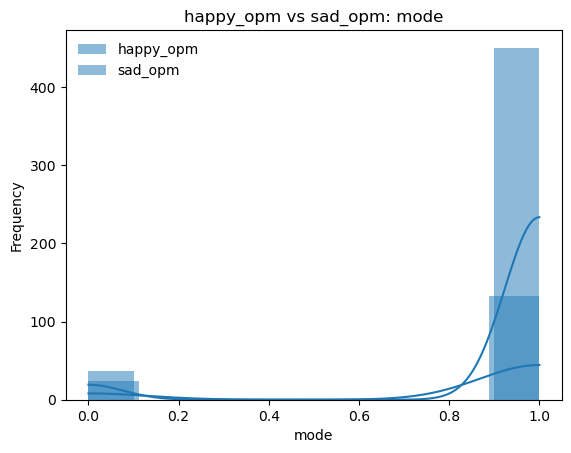

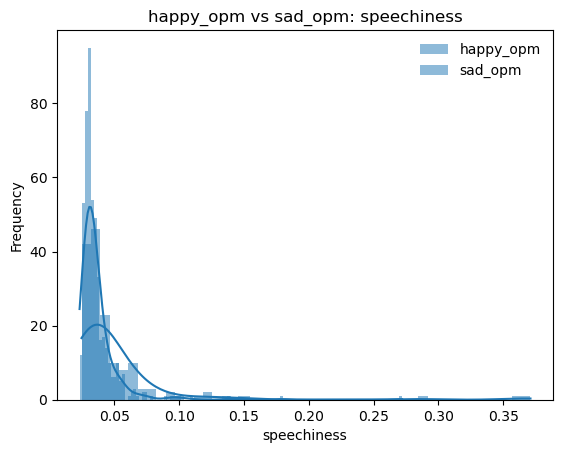

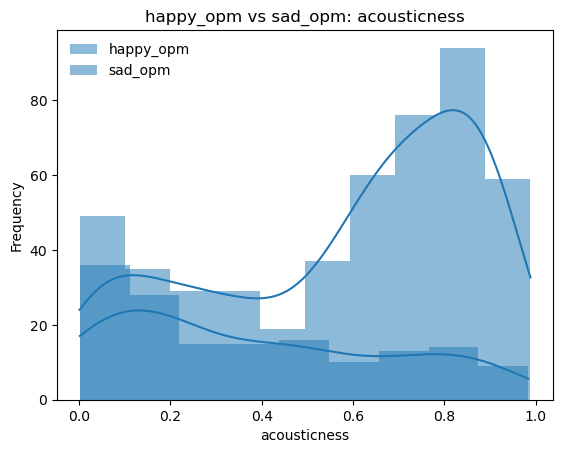

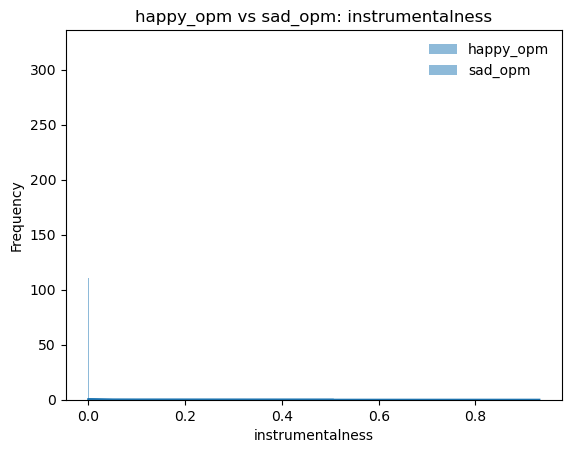

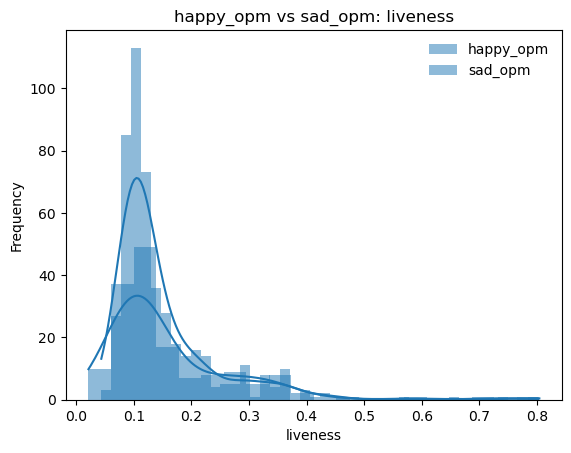

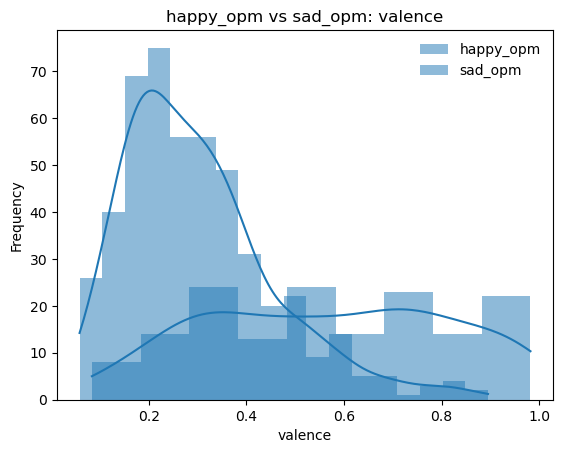

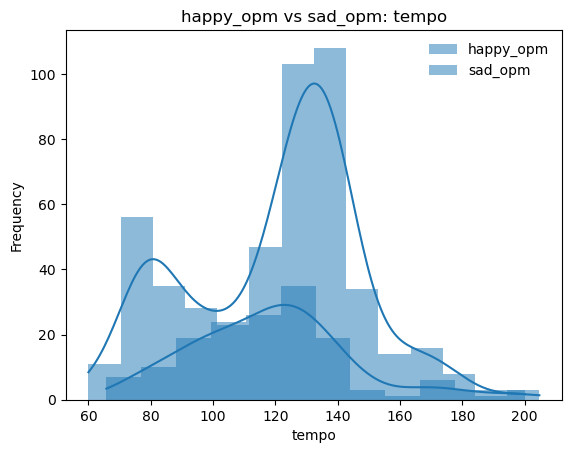

In [26]:
for col in ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']:
    fig,ax = plt.subplots()
    for genre in compare_genres:
       data = tracks_df[tracks_df['genre']==genre]
       sns.histplot(data[col], ax=ax, label= genre, kde=True, edgecolor='None')
    plt.title(f"{compare_genres[0]} vs {compare_genres[1]}: {col}")
    plt.ylabel('Frequency')
    plt.legend(frameon=False)
    plt.show()

>Q: What feature/s best distinguish the 2 categories from each other? Does it make sense to use this as a feature for a classification model?

###############################################

Explanation here

###############################################

## 3. Feature Engineering

**Categorical Encoding**
Since supervised models only takes in integers as labels, we map genres to numbers

In [27]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,artist_name,num_artists,album_id,release_date,playlist_id,playlist_name,duration_mins,genre,duration,genre_id
0,3rcIETyqsnaFShhWCtywaA,0.796,0.810,3,-3.973,0,0.0347,0.0119,0.000136,0.1250,...,Janella Salvador,1.0,5ExrCnkKUNwQHtzzAVdL4B,2015-01-01,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.014433,happy_opm,NaN,1
1,0wDOW3KujYyW6hIFmhHgIF,0.730,0.746,3,-5.349,1,0.0312,0.0862,0.000000,0.1690,...,Harana,1.0,49SJlnu4AMpyHkMSymozsN,2015-01-01,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.198667,happy_opm,NaN,1
2,0o5Vy8oK1sfMsHD2Dr6D4k,0.540,0.827,3,-4.958,0,0.1230,0.2760,0.000014,0.2190,...,Sarah Geronimo,1.0,6XyCKRUSZTALq3AJgb7Dqu,2014-10-04,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.186883,happy_opm,NaN,1
3,2Ccg5O8xZUtfXloVOykOiu,0.598,0.795,8,-1.602,1,0.0497,0.6230,0.000193,0.0971,...,Sarah Geronimo,1.0,2MCThGZYlAQRw3HDjkIODU,2015-12-04,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,4.084217,happy_opm,NaN,1
4,4ai7c2BUjNpElhZdZDH7qF,0.764,0.894,0,-2.892,1,0.0327,0.2270,0.000000,0.0906,...,Inigo Pascual,1.0,7dT7OfZcmX7HjE8EBqehEF,2016-10-21,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.520000,happy_opm,NaN,1


Build dictionary of label ids for later

In [28]:
genre_lookup = tracks_df[['genre_id','genre']].drop_duplicates()\
                        .sort_values('genre_id')\
                        .set_index('genre_id')\
                        .to_dict()['genre']
genre_lookup

{0: 'chill_opm', 1: 'happy_opm', 2: 'hugot_opm', 3: 'sad_opm'}

Select audio features to use for the model

In [29]:
# create feature matrix (X)
# pick energy and tempo as features
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
print(len(X),len(y))

1514 1514


Add to matrices

In [30]:
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

Split to train and test set

In [31]:
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

## 4. Train Models

In [34]:
scaler = MinMaxScaler()
sampling_reports_by_fbeta_df = load_or_run('baseline_reports_allmodels_semantic_opms_hale.csv',
                                 evaluate_sampling_techniques, X_trainval, y_trainval, scaler=scaler).sort_values(by='ave_val_acc', ascending=False)

Evaluating models with SMOTE sampling technique with MinMaxScaler...


  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.62it/s]
2it [00:00,  4.76it/s]
3it [00:00,  4.75it/s]
4it [00:00,  4.72it/s]
5it [00:01,  4.75it/s]
  9%|▉         | 1/11 [00:01<00:10,  1.06s/it]
0it [00:00, ?it/s]
1it [00:01,  1.09s/it]
2it [00:01,  1.46it/s]
3it [00:01,  1.78it/s]
4it [00:02,  1.96it/s]
5it [00:02,  1.80it/s]
 18%|█▊        | 2/11 [00:03<00:18,  2.07s/it]
0it [00:00, ?it/s]
2it [00:00, 17.57it/s]
5it [00:00, 17.40it/s]
 27%|██▋       | 3/11 [00:04<00:10,  1.26s/it]
0it [00:00, ?it/s]
1it [00:00,  2.12it/s]
2it [00:00,  2.10it/s]
3it [00:01,  2.17it/s]
4it [00:01,  2.17it/s]
5it [00:02,  2.17it/s]
 36%|███▋      | 4/11 [00:06<00:11,  1.67s/it]
0it [00:00, ?it/s]
1it [00:02,  2.95s/it]
2it [00:05,  2.95s/it]
3it [00:08,  2.96s/it]
4it [00:11,  2.96s/it]
5it [00:14,  2.96s/it]
 45%|████▌     | 5/11 [00:21<00:38,  6.41s/it]
0it [00:00, ?it/s]
1it [00:00,  3.01it/s]
2it [00:00,  3.03it/s]
3it [00:00,  3.04it/s]
4it [00:01,  3.03it/s]
5it [00:01,  3

Report Generated in 30.72 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler                SMOTE     99.649038   
Random Forest        MinMaxScaler                SMOTE     99.649038   
XGBoost              MinMaxScaler                SMOTE     99.566457   
Gradient Boosting    MinMaxScaler                SMOTE     81.812638   
LinearSVM            MinMaxScaler                SMOTE     45.334139   
Decision Tree        MinMaxScaler                SMOTE     99.649038   
RadialSVM            MinMaxScaler                SMOTE     48.740096   
PolynomialSVM        MinMaxScaler                SMOTE     48.884617   
KNN                  MinMaxScaler                SMOTE     65.379619   
Logistic Regression  MinMaxScaler                SMOTE     43.042563   
AdaBoost             MinMaxScaler                SMOTE     44.921598   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees            54

  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.31it/s]
2it [00:00,  4.40it/s]
3it [00:00,  4.59it/s]
4it [00:00,  4.62it/s]
5it [00:01,  4.55it/s]
  9%|▉         | 1/11 [00:01<00:11,  1.10s/it]
0it [00:00, ?it/s]
1it [00:00,  2.25it/s]
2it [00:00,  2.28it/s]
3it [00:01,  2.31it/s]
5it [00:01,  3.41it/s]
 18%|█▊        | 2/11 [00:02<00:11,  1.32s/it]
0it [00:00, ?it/s]
2it [00:00, 14.54it/s]
5it [00:00, 14.60it/s]
 27%|██▋       | 3/11 [00:02<00:07,  1.14it/s]
0it [00:00, ?it/s]
1it [00:00,  1.99it/s]
2it [00:01,  2.00it/s]
3it [00:01,  2.01it/s]
4it [00:01,  2.05it/s]
5it [00:02,  2.04it/s]
 36%|███▋      | 4/11 [00:05<00:10,  1.50s/it]
0it [00:00, ?it/s]
1it [00:03,  3.03s/it]
2it [00:06,  3.00s/it]
3it [00:09,  3.01s/it]
4it [00:12,  3.03s/it]
5it [00:15,  3.02s/it]
 45%|████▌     | 5/11 [00:20<00:38,  6.40s/it]
0it [00:00, ?it/s]
1it [00:00,  2.97it/s]
2it [00:00,  2.99it/s]
3it [00:01,  2.95it/s]
4it [00:01,  2.95it/s]
5it [00:01,  2.96it/s]
 55%|█████▍   

Report Generated in 30.42 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler               ADASYN     99.649038   
Random Forest        MinMaxScaler               ADASYN     99.649038   
XGBoost              MinMaxScaler               ADASYN     99.566457   
Gradient Boosting    MinMaxScaler               ADASYN     81.523659   
Decision Tree        MinMaxScaler               ADASYN     99.649038   
LinearSVM            MinMaxScaler               ADASYN     42.815482   
RadialSVM            MinMaxScaler               ADASYN     46.779226   
KNN                  MinMaxScaler               ADASYN     65.008273   
PolynomialSVM        MinMaxScaler               ADASYN     47.460767   
Logistic Regression  MinMaxScaler               ADASYN     40.978025   
AdaBoost             MinMaxScaler               ADASYN     43.456192   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees            55

  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.77it/s]
2it [00:00,  4.75it/s]
3it [00:00,  4.78it/s]
4it [00:00,  4.79it/s]
5it [00:01,  4.78it/s]
  9%|▉         | 1/11 [00:01<00:10,  1.05s/it]
0it [00:00, ?it/s]
2it [00:00, 11.95it/s]
5it [00:00, 11.83it/s]
 18%|█▊        | 2/11 [00:01<00:06,  1.46it/s]
0it [00:00, ?it/s]
2it [00:00, 14.91it/s]
5it [00:00, 14.88it/s]
 27%|██▋       | 3/11 [00:01<00:04,  1.90it/s]
0it [00:00, ?it/s]
1it [00:00,  2.47it/s]
2it [00:00,  2.52it/s]
3it [00:01,  2.44it/s]
4it [00:01,  2.45it/s]
5it [00:02,  2.46it/s]
 36%|███▋      | 4/11 [00:03<00:07,  1.12s/it]
0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
2it [00:01,  1.25it/s]
3it [00:02,  1.24it/s]
4it [00:03,  1.24it/s]
5it [00:04,  1.24it/s]
 45%|████▌     | 5/11 [00:07<00:12,  2.17s/it]
0it [00:00, ?it/s]
1it [00:00,  4.61it/s]
2it [00:00,  4.60it/s]
3it [00:00,  4.58it/s]
4it [00:00,  4.57it/s]
5it [00:01,  4.57it/s]
 55%|█████▍    | 6/11 [00:08<00:09,  1.80s/it]
0it [00:00, ?

Report Generated in 12.67 seconds
                          scaling resampling_technique ave_train_acc  \
LinearSVM            MinMaxScaler             NearMiss     39.987953   
KNN                  MinMaxScaler             NearMiss     43.311691   
PolynomialSVM        MinMaxScaler             NearMiss     37.509808   
RadialSVM            MinMaxScaler             NearMiss     36.973279   
Logistic Regression  MinMaxScaler             NearMiss      33.19572   
ExtraTrees           MinMaxScaler             NearMiss      45.58218   
Random Forest        MinMaxScaler             NearMiss     45.974358   
Decision Tree        MinMaxScaler             NearMiss     47.729256   
Gradient Boosting    MinMaxScaler             NearMiss     45.953739   
XGBoost              MinMaxScaler             NearMiss     45.705848   
AdaBoost             MinMaxScaler             NearMiss     34.042359   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
LinearSVM             39

  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.62it/s]
2it [00:00,  4.70it/s]
3it [00:00,  4.93it/s]
4it [00:00,  4.84it/s]
5it [00:01,  4.88it/s]
  9%|▉         | 1/11 [00:01<00:10,  1.03s/it]
0it [00:00, ?it/s]
2it [00:00, 15.70it/s]
5it [00:00, 15.44it/s]
 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]
0it [00:00, ?it/s]
2it [00:00, 19.30it/s]
5it [00:00, 20.69it/s]
 27%|██▋       | 3/11 [00:01<00:03,  2.24it/s]
0it [00:00, ?it/s]
1it [00:00,  2.47it/s]
2it [00:00,  2.42it/s]
3it [00:01,  2.40it/s]
4it [00:01,  2.39it/s]
5it [00:02,  2.40it/s]
 36%|███▋      | 4/11 [00:03<00:07,  1.10s/it]
0it [00:00, ?it/s]
1it [00:01,  1.33s/it]
2it [00:02,  1.33s/it]
3it [00:03,  1.33s/it]
4it [00:05,  1.32s/it]
5it [00:06,  1.32s/it]
 45%|████▌     | 5/11 [00:10<00:18,  3.09s/it]
0it [00:00, ?it/s]
1it [00:00,  4.44it/s]
2it [00:00,  4.30it/s]
3it [00:00,  4.33it/s]
4it [00:00,  4.36it/s]
5it [00:01,  4.36it/s]
 55%|█████▍    | 6/11 [00:11<00:12,  2.43s/it]
0it [00:00, ?

Report Generated in 16.05 seconds
                          scaling resampling_technique ave_train_acc  \
Random Forest        MinMaxScaler           TomekLinks     89.719251   
ExtraTrees           MinMaxScaler           TomekLinks     89.574751   
PolynomialSVM        MinMaxScaler           TomekLinks     61.767435   
RadialSVM            MinMaxScaler           TomekLinks     60.322369   
LinearSVM            MinMaxScaler           TomekLinks     59.207392   
Logistic Regression  MinMaxScaler           TomekLinks     58.402204   
XGBoost              MinMaxScaler           TomekLinks     89.327052   
KNN                  MinMaxScaler           TomekLinks     66.143784   
Gradient Boosting    MinMaxScaler           TomekLinks     83.773636   
AdaBoost             MinMaxScaler           TomekLinks     55.945573   
Decision Tree        MinMaxScaler           TomekLinks     88.377491   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
Random Forest         59

  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.47it/s]
2it [00:00,  4.14it/s]
3it [00:00,  4.50it/s]
4it [00:00,  4.32it/s]
5it [00:01,  4.33it/s]
  9%|▉         | 1/11 [00:01<00:11,  1.16s/it]
0it [00:00, ?it/s]
2it [00:00, 10.32it/s]
5it [00:00, 10.03it/s]
 18%|█▊        | 2/11 [00:01<00:06,  1.29it/s]
0it [00:00, ?it/s]
2it [00:00, 11.93it/s]
5it [00:00, 11.68it/s]
 27%|██▋       | 3/11 [00:02<00:04,  1.62it/s]
0it [00:00, ?it/s]
1it [00:00,  1.99it/s]
2it [00:00,  2.03it/s]
3it [00:01,  2.00it/s]
4it [00:01,  2.02it/s]
5it [00:02,  2.00it/s]
 36%|███▋      | 4/11 [00:04<00:09,  1.36s/it]
0it [00:00, ?it/s]
1it [00:02,  2.96s/it]
2it [00:05,  2.95s/it]
3it [00:08,  2.91s/it]
4it [00:11,  2.89s/it]
5it [00:14,  2.89s/it]
 45%|████▌     | 5/11 [00:19<00:36,  6.09s/it]
0it [00:00, ?it/s]
1it [00:00,  2.91it/s]
2it [00:00,  2.86it/s]
3it [00:01,  2.88it/s]
4it [00:01,  2.88it/s]
5it [00:01,  2.89it/s]
 55%|█████▍    | 6/11 [00:20<00:23,  4.61s/it]
0it [00:00, ?

Report Generated in 29.01 seconds
                          scaling resampling_technique ave_train_acc  \
ExtraTrees           MinMaxScaler           SMOTETomek     96.758778   
Random Forest        MinMaxScaler           SMOTETomek     96.387155   
XGBoost              MinMaxScaler           SMOTETomek     96.490439   
Gradient Boosting    MinMaxScaler           SMOTETomek     80.161067   
Decision Tree        MinMaxScaler           SMOTETomek     96.242825   
LinearSVM            MinMaxScaler           SMOTETomek     44.095301   
RadialSVM            MinMaxScaler           SMOTETomek     47.460256   
KNN                  MinMaxScaler           SMOTETomek     64.430038   
PolynomialSVM        MinMaxScaler           SMOTETomek     47.584436   
AdaBoost             MinMaxScaler           SMOTETomek     45.706083   
Logistic Regression  MinMaxScaler           SMOTETomek     41.494277   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
ExtraTrees            56

  0%|          | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  4.42it/s]
2it [00:00,  4.25it/s]
3it [00:00,  4.36it/s]
4it [00:00,  4.19it/s]
5it [00:01,  4.19it/s]
  9%|▉         | 1/11 [00:01<00:11,  1.20s/it]
0it [00:00, ?it/s]
1it [00:00,  7.35it/s]
2it [00:00,  7.39it/s]
3it [00:00,  7.93it/s]
4it [00:00,  7.93it/s]
5it [00:00,  8.06it/s]
 18%|█▊        | 2/11 [00:01<00:07,  1.16it/s]
0it [00:00, ?it/s]
1it [00:00,  9.54it/s]
2it [00:00,  9.47it/s]
3it [00:00,  9.46it/s]
5it [00:00,  9.66it/s]
 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]
0it [00:00, ?it/s]
1it [00:00,  2.23it/s]
2it [00:00,  2.18it/s]
3it [00:01,  2.19it/s]
4it [00:01,  2.20it/s]
5it [00:02,  2.20it/s]
 36%|███▋      | 4/11 [00:04<00:09,  1.33s/it]
0it [00:00, ?it/s]
1it [00:01,  1.84s/it]
2it [00:03,  1.84s/it]
3it [00:05,  1.85s/it]
4it [00:07,  1.87s/it]
5it [00:09,  1.85s/it]
 45%|████▌     | 5/11 [00:13<00:25,  4.19s/it]
0it [00:00, ?it/s]
1it [00:00,  3.09it/s]
2it [00:00,  3.14it/s]
3it [00:00,  3

Report Generated in 21.04 seconds
                          scaling resampling_technique ave_train_acc  \
XGBoost              MinMaxScaler             SMOTEENN     48.843935   
Gradient Boosting    MinMaxScaler             SMOTEENN     47.522793   
Random Forest        MinMaxScaler             SMOTEENN     47.729192   
Decision Tree        MinMaxScaler             SMOTEENN     49.173767   
ExtraTrees           MinMaxScaler             SMOTEENN     47.625971   
AdaBoost             MinMaxScaler             SMOTEENN     32.246096   
PolynomialSVM        MinMaxScaler             SMOTEENN     31.936498   
KNN                  MinMaxScaler             SMOTEENN     39.016985   
RadialSVM            MinMaxScaler             SMOTEENN     27.374071   
Logistic Regression  MinMaxScaler             SMOTEENN     18.889735   
LinearSVM            MinMaxScaler             SMOTEENN      16.49594   

                    ave_val_acc ave_train_prec ave_val_prec ave_train_rec  \
XGBoost               35

In [35]:
sampling_reports_by_fbeta_df.to_csv('baseline_reports_minmaxscaler_semantic_opms_hale.csv')

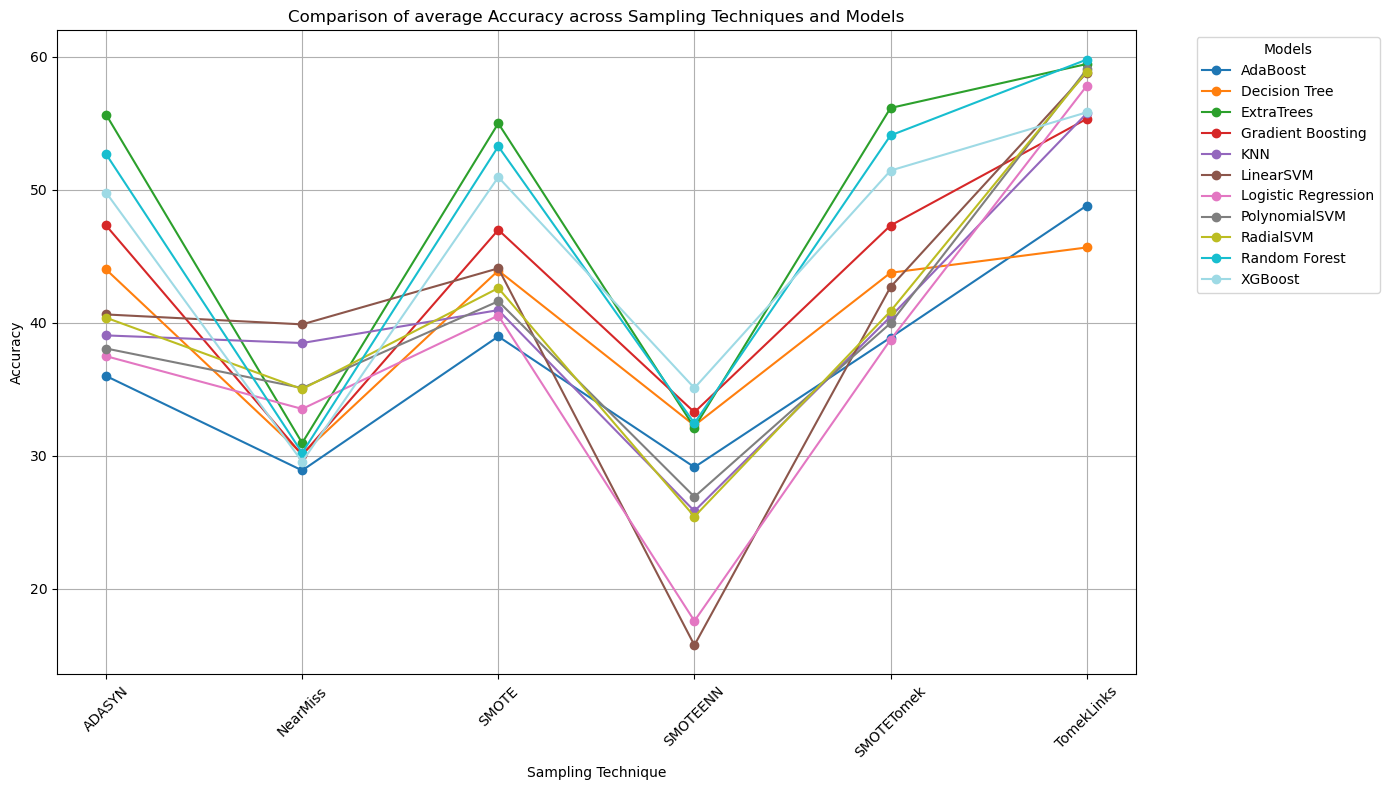

In [36]:
plot_line_comparison_models(sampling_reports_by_fbeta_df, 'ave_val_acc',
                            'Comparison of average Accuracy across Sampling Techniques and Models',
                            'Sampling Technique', 'Accuracy')

In [39]:
top5_acc = sampling_reports_by_fbeta_df.head(10).reset_index(drop=True)
display(top5_acc)

,Sampling Technique,Model,scaling,resampling_technique,ave_train_acc,ave_val_acc,ave_train_prec,ave_val_prec,ave_train_rec,ave_val_rec,ave_train_f1,ave_val_f1,run_time,results
0,TomekLinks,Random Forest,MinMaxScaler,TomekLinks,89.719251,59.787777,90.053467,57.080179,89.719251,59.787777,89.530383,55.522881,2.090025,"{'train_scores': [0.8977272727272727, 0.899896..."
1,TomekLinks,ExtraTrees,MinMaxScaler,TomekLinks,89.574751,59.456518,89.906513,56.879612,89.574751,59.456518,89.378983,55.491755,1.453219,"{'train_scores': [0.8966942148760331, 0.895768..."
2,TomekLinks,PolynomialSVM,MinMaxScaler,TomekLinks,61.767435,59.044995,65.095117,52.962424,61.767435,59.044995,56.715171,53.561561,0.591968,"{'train_scores': [0.6322314049586777, 0.616099..."
3,TomekLinks,RadialSVM,MinMaxScaler,TomekLinks,60.322369,58.879026,57.669367,50.253784,60.322369,58.879026,53.622034,52.063787,0.663666,"{'train_scores': [0.618801652892562, 0.6068111..."
4,TomekLinks,LinearSVM,MinMaxScaler,TomekLinks,59.207392,58.794341,47.991336,47.675145,59.207392,58.794341,52.672601,52.308528,0.47489,"{'train_scores': [0.5981404958677686, 0.590299..."
5,TomekLinks,Logistic Regression,MinMaxScaler,TomekLinks,58.402204,57.804306,57.522946,48.894672,58.402204,57.804306,52.051526,51.36503,0.32684,"{'train_scores': [0.5867768595041323, 0.579979..."
6,SMOTETomek,ExtraTrees,MinMaxScaler,SMOTETomek,96.758778,56.152093,96.77731,55.406546,96.758778,56.152093,96.76037,55.677953,1.97564,"{'train_scores': [0.9628099173553719, 0.972136..."
7,TomekLinks,XGBoost,MinMaxScaler,TomekLinks,89.327052,55.821855,89.520626,53.194482,89.327052,55.821855,89.165572,53.303229,1.392542,"{'train_scores': [0.8956611570247934, 0.892672..."
8,TomekLinks,KNN,MinMaxScaler,TomekLinks,66.143784,55.73887,65.133673,53.177775,66.143784,55.73887,64.201748,53.223815,1.026913,"{'train_scores': [0.6663223140495868, 0.649122..."
9,ADASYN,ExtraTrees,MinMaxScaler,ADASYN,99.649038,55.658606,99.651009,55.603431,99.649038,55.658606,99.648693,55.501471,1.998585,"{'train_scores': [0.9958677685950413, 0.996904..."


# Hyperparameter Tuning

In [45]:
top_algorithms = ['Random Forest', 'ExtraTrees', 'LinearSVM', 'PolynomialSVM', 'RadialSVM']
params_and_metrics = load_or_run('tomeklinks_semantic_opm_params_and_metrics_hale.csv',
                                 tune_top_models, X_trainval, y_trainval, top_algorithms, scorer=make_scorer(accuracy_score), 
                                 sampling_technique=TomekLinks(),
                                 n_splits=5).sort_values(by='test_accuracy', ascending=False)
display(params_and_metrics)

The top algorithms are: ['Random Forest', 'ExtraTrees', 'LinearSVM', 'PolynomialSVM', 'RadialSVM']
Tuning for Random Forest
Tuning for ExtraTrees
Tuning for LinearSVM
Tuning for PolynomialSVM
Tuning for RadialSVM


,best_params,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_f1,val_f1,runtime
ExtraTrees,"{'Model__bootstrap': False, 'Model__criterion'...",0.756608,0.607261,0.756608,0.607261,0.781508,0.552427,0.737009,0.550301,24.1461
Random Forest,"{'Model__bootstrap': True, 'Model__criterion':...",0.872247,0.60066,0.872247,0.60066,0.875368,0.587307,0.870701,0.550829,29.446811
RadialSVM,"{'Model__C': 1.0, 'Model__gamma': 'auto', 'Mod...",0.638767,0.590759,0.638767,0.590759,0.673105,0.509878,0.599938,0.531055,15.160793
PolynomialSVM,"{'Model__C': 1.0, 'Model__coef0': 1.0, 'Model_...",0.669604,0.577558,0.669604,0.577558,0.679268,0.528076,0.643391,0.533579,17.345246
LinearSVM,"{'Model__C': 0.1, 'Model__random_state': 11}",0.602423,0.570957,0.602423,0.570957,0.49075,0.457723,0.537833,0.507755,15.397649


In [43]:
top_algorithms = ['KNN', 'LinearSVM', 'PolynomialSVM', 'RadialSVM']
tomeklinks_params_and_metrics = load_or_run('tomeklinks_knn_svm_params_and_metrics_hale.csv',
                                 tune_top_models, X_trainval, y_trainval, top_algorithms, scorer=make_scorer(accuracy_score), 
                                 sampling_technique=TomekLinks(),
                                 n_splits=5).sort_values(by='test_accuracy', ascending=False)


The top algorithms are: ['KNN', 'LinearSVM', 'PolynomialSVM', 'RadialSVM']
Tuning for KNN
Tuning for LinearSVM
Tuning for PolynomialSVM
Tuning for RadialSVM


In [47]:
display(tomeklinks_params_and_metrics)

NameError: name 'tomeklinks_params_and_metrics' is not defined

# Model Evaluation

In [49]:
params_and_metrics.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

,best_params,train_accuracy,test_accuracy,train_recall,test_recall,train_precision,test_precision,train_f1,val_f1,runtime
0,"{'Model__bootstrap': False, 'Model__criterion'...",0.756608,0.607261,0.756608,0.607261,0.781508,0.552427,0.737009,0.550301,24.1461
1,"{'Model__bootstrap': True, 'Model__criterion':...",0.872247,0.60066,0.872247,0.60066,0.875368,0.587307,0.870701,0.550829,29.446811
2,"{'Model__C': 1.0, 'Model__gamma': 'auto', 'Mod...",0.638767,0.590759,0.638767,0.590759,0.673105,0.509878,0.599938,0.531055,15.160793
3,"{'Model__C': 1.0, 'Model__coef0': 1.0, 'Model_...",0.669604,0.577558,0.669604,0.577558,0.679268,0.528076,0.643391,0.533579,17.345246
4,"{'Model__C': 0.1, 'Model__random_state': 11}",0.602423,0.570957,0.602423,0.570957,0.49075,0.457723,0.537833,0.507755,15.397649


In [50]:
params_and_metrics.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True).best_params[0]

OrderedDict([('Model__bootstrap', False),
             ('Model__criterion', 'entropy'),
             ('Model__max_depth', 30),
             ('Model__min_samples_leaf', 2),
             ('Model__min_samples_split', 10),
             ('Model__n_estimators', 150)])

In [51]:
from collections import OrderedDict
best_params = params_and_metrics.sort_values(by='test_accuracy', ascending=False).reset_index(drop=True).best_params[0]
best_params = OrderedDict((k.replace('Model__', ''), v) for k, v in best_params.items())
best_params

OrderedDict([('bootstrap', False),
             ('criterion', 'entropy'),
             ('max_depth', 30),
             ('min_samples_leaf', 2),
             ('min_samples_split', 10),
             ('n_estimators', 150)])

In [52]:
best_params['random_state'] = 42
# best_params['kernel'] = 'linear'
best_params

OrderedDict([('bootstrap', False),
             ('criterion', 'entropy'),
             ('max_depth', 30),
             ('min_samples_leaf', 2),
             ('min_samples_split', 10),
             ('n_estimators', 150),
             ('random_state', 42)])

Classification Report:
              precision    recall  f1-score   support

   chill_opm       0.63      0.87      0.73       149
   happy_opm       1.00      0.13      0.23        31
   hugot_opm       0.00      0.00      0.00        25
     sad_opm       0.61      0.57      0.59        98

    accuracy                           0.62       303
   macro avg       0.56      0.39      0.39       303
weighted avg       0.61      0.62      0.57       303

Confusion Matrix:
[[129   0   0  20]
 [ 23   4   0   4]
 [ 13   0   0  12]
 [ 41   0   1  56]]


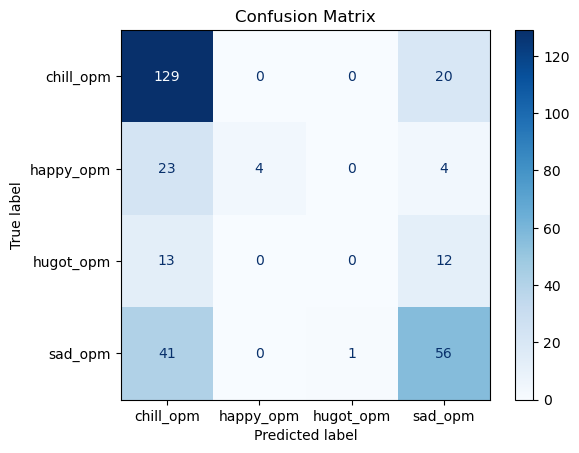

Training Accuracy: 0.7440132122213047
Testing Accuracy: 0.6237623762376238
Training Recall: 0.7440132122213047
Test Recall: 0.6237623762376238
Precision: 0.6071221094249569
F1 Score: 0.5714239580264285


In [54]:

best_model = ExtraTreesClassifier(**best_params)

pipeline, test_accuracy = evaluate_model(best_model, X_trainval, y_trainval, X_holdout, y_holdout, scaler=MinMaxScaler(),
                            sampling_technique=TomekLinks(), features=None,  target_names=genre_lookup.values(),
                                         filename='tomeklinks_extratrees_semantic_opm_final')

In [55]:
best_model_pipeline = pipeline

best_model = best_model_pipeline.named_steps['model']
best_model_scaler = best_model_pipeline.named_steps['scaler']

In [56]:
tracks_df['predicted_genre_id'] = best_model_pipeline.predict(tracks_df[feature_cols])
tracks_df['predicted_genre'] = tracks_df['predicted_genre_id'].map(genre_lookup)
tracks_df

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,album_id,release_date,playlist_id,playlist_name,duration_mins,genre,duration,genre_id,predicted_genre_id,predicted_genre
0,3rcIETyqsnaFShhWCtywaA,0.796,0.810,3,-3.973,0,0.0347,0.0119,0.000136,0.1250,...,5ExrCnkKUNwQHtzzAVdL4B,2015-01-01,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.014433,happy_opm,NaN,1,1,happy_opm
1,0wDOW3KujYyW6hIFmhHgIF,0.730,0.746,3,-5.349,1,0.0312,0.0862,0.000000,0.1690,...,49SJlnu4AMpyHkMSymozsN,2015-01-01,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.198667,happy_opm,NaN,1,1,happy_opm
2,0o5Vy8oK1sfMsHD2Dr6D4k,0.540,0.827,3,-4.958,0,0.1230,0.2760,0.000014,0.2190,...,6XyCKRUSZTALq3AJgb7Dqu,2014-10-04,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.186883,happy_opm,NaN,1,0,chill_opm
3,2Ccg5O8xZUtfXloVOykOiu,0.598,0.795,8,-1.602,1,0.0497,0.6230,0.000193,0.0971,...,2MCThGZYlAQRw3HDjkIODU,2015-12-04,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,4.084217,happy_opm,NaN,1,0,chill_opm
4,4ai7c2BUjNpElhZdZDH7qF,0.764,0.894,0,-2.892,1,0.0327,0.2270,0.000000,0.0906,...,7dT7OfZcmX7HjE8EBqehEF,2016-10-21,0BlH9dSprBFq6ftgjkvPgh,Happy OPM Songs,3.520000,happy_opm,NaN,1,1,happy_opm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0R16V3ua0CNeRJN7YygKWW,0.507,0.595,4,-5.052,1,0.0300,0.2660,0.000000,0.1120,...,6ZdRPC3q9HWnVa2vnUG6Zm,2019-09-13,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,277000.0,2,3,sad_opm
231,42O7mssBsIgd7hSbHIDQM8,0.394,0.393,9,-6.324,1,0.0316,0.7180,0.000040,0.1230,...,3gs5h0S1MsOnfTOlQ5km7B,2005-12-20,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,261146.0,2,3,sad_opm
233,3Sci6bvEJ9pjzSMuEVIzQF,0.719,0.520,2,-9.361,1,0.0744,0.4700,0.000000,0.0724,...,3ppZGR77odiva6AcYUKFQH,2014-03-06,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,198666.0,2,0,chill_opm
234,0ZYNxGSgpHxhRME8KjTMnH,0.400,0.285,4,-12.392,1,0.0283,0.1120,0.000000,0.1100,...,35quT42Y3dDuuLFz3oAXYp,2013-05-15,4qFgUZucr2xW5BZHHs7Quk,Hugot OPM 🌻,NaN,hugot_opm,253853.0,2,2,hugot_opm


In [57]:
joblib.dump(best_model_pipeline,'genre_classifier_hale_tomeklinks_extratrees_semantic.pkl')

['genre_classifier_hale_tomeklinks_extratrees_semantic.pkl']

## 6. Feature Importance

Use scaler from pipeline to transform

In [ ]:
features = best_model_scaler.transform(X_train)

Run SHAP explainer and get importance values

In [ ]:
explainer = shap.TreeExplainer(best_model,\
                            feature_names=feature_cols)
shap_values = explainer.shap_values(features)

KeyboardInterrupt: ignored

In [ ]:
shap.summary_plot(shap_values=shap_values,
                  features = features,
                  feature_names = feature_cols,
                  class_names = list(genre_lookup.values()),
                  plot_type = "bar")

>Q: Pick a track and verify as a listener if you agree with the predicted genre and how shap explains it

In [ ]:
# Get sample track and index, scale features
sample = tracks_df[tracks_df['track_name'].str.contains('Under Pressure')]
sample_idx = sample.index.values[0]
sample_features = best_model_scaler.transform(sample[feature_cols])
sample

In [ ]:
# Plot force plot per genre
shap_values = explainer.shap_values(sample_features)
shap.initjs()
for genre_id in range(8):
    print(genre_lookup[genre_id])
    display(shap.force_plot(explainer.expected_value[genre_id], shap_values[genre_id], sample_features,\
                             feature_names=feature_cols))
